In [1]:
import requests, urllib, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns

In [2]:
dataset_id = "d_4a6347a51983571d5a5ccfda425266ed"
column_filters = ""
row_filters = {}
offset = None
sort = None
filters = {}
for key, value in row_filters.items():
    filters[key] = {
        "type": "ILIKE",
        "value": str(value) if value is not None else ""
    }

row_filters_encoded = urllib.parse.quote(json.dumps(filters))

params = {
    "resource_id": dataset_id,
    "limit": 999
}
if column_filters:
    params["fields"] = column_filters
if filters:
    params["filters"] = row_filters_encoded
if offset:
    params["offset"] = offset
if sort:
    params["sort"] = sort

url = "https://data.gov.sg/api/action/datastore_search"
response = requests.get(url, params=params)
print(json.dumps(response.json(), indent=2))

{
  "help": "https://data.gov.sg/api/3/action/help_show?name=datastore_search",
  "success": true,
  "result": {
    "resource_id": "d_4a6347a51983571d5a5ccfda425266ed",
    "fields": [
      {
        "type": "text",
        "id": "DataSeries"
      },
      {
        "type": "numeric",
        "id": "2023"
      },
      {
        "type": "numeric",
        "id": "2022"
      },
      {
        "type": "numeric",
        "id": "2021"
      },
      {
        "type": "numeric",
        "id": "2020"
      },
      {
        "type": "numeric",
        "id": "2019"
      },
      {
        "type": "numeric",
        "id": "2018"
      },
      {
        "type": "numeric",
        "id": "2017"
      },
      {
        "type": "numeric",
        "id": "2016"
      },
      {
        "type": "numeric",
        "id": "2015"
      },
      {
        "type": "numeric",
        "id": "2014"
      },
      {
        "type": "numeric",
        "id": "2013"
      },
      {
        "type": "numeri

In [3]:
def _display_all_columns(data:pd.DataFrame)->None:
    with pd.option_context('display.max_columns', None):
        display(data)

In [4]:
data = response.json()
records = data['result']['records']
df = pd.DataFrame(records)
df['DataSeries'] = df['DataSeries'].str.replace(r'(?i)\baged?\b\s+|\s+\bye?a?rs?\b', '', regex=True).str.strip()
df['SubDataSeries'] = df['DataSeries'].where(df['DataSeries'].str.startswith('Grooms'))
df['DataSeries'] = df['DataSeries'].where(df['SubDataSeries'].isna()).ffill()
df['SubDataSeries'] = df['SubDataSeries'].fillna('Total')
df['DataSeries'] = df['DataSeries'].str.replace(r'(?i)^brides?\W*', '', regex=True).str.replace(r'[^a-zA-Z0-9&]+', ' ').str.title().str.strip()
df['SubDataSeries'] = df['SubDataSeries'].str.replace(r'(?i)^grooms?\W*', '', regex=True).str.replace(r'[^a-zA-Z0-9&]+', ' ').str.title().str.strip()
df = df.rename(columns={'DataSeries': 'brides', 'SubDataSeries': 'grooms'}).drop(columns=['_id'])
df['grooms'] = df['grooms'].replace({'40-44': '40+', '45-49': '40+', '50-54': '40+', '55-59': '40+', '60 & Over': '40+', })
df['brides'] = df['brides'].replace({'40-44': '40+', '45-49': '40+', '50-54': '40+', '55-59': '40+', '60 & Over': '40+', })
df['brides'] = pd.Categorical(df['brides'], ['Under 20', '20-24', '25-29', '30-34', '35-39', '40+', 'Total'], ordered=True)
df['grooms'] = pd.Categorical(df['grooms'], ['Under 20', '20-24', '25-29', '30-34', '35-39', '40+', 'Total'], ordered=True)
df['comparison'] = df['grooms'].lt(df['brides']).map({True: 'Groom < Bride', False: 'Groom = Bride'}).where(df['grooms'].le(df['brides']), 'Groom > Bride')
df['comparison'] = pd.Categorical(df['comparison'], ['Groom < Bride', 'Groom = Bride', 'Groom > Bride'], ordered=True)
for col in df.drop(columns=['brides', 'grooms', 'comparison']).columns:
    try:
        df[col] = df[col].astype('int')
    except:
        df[col] = df[col].str.strip().astype('int')
df = df.groupby(by=['brides', 'grooms', 'comparison'], observed=True).sum()
df = df.rename(columns=int).astype('int').transpose().sort_index(axis=0).sort_index(axis=1).copy(deep=True)
# df = df.set_index(keys=['brides', 'grooms', 'comparison']).rename(columns=int).astype('int').transpose().sort_index(axis=0).sort_index(axis=1).copy(deep=True)
# df = df.set_index(keys=['brides', 'grooms']).rename(columns=int).astype('int').unstack(level=0).sort_index(axis=0).sort_index(axis=1).copy(deep=True)
assert isinstance(df, pd.DataFrame)
_display_all_columns(df.T)

1983   1984   1985   1986   1987   1988  \
brides   grooms   comparison                                                
Under 20 Under 20 Groom = Bride     65     49     52     47     46     40   
         20-24    Groom > Bride    811    718    671    488    513    451   
         25-29    Groom > Bride    417    350    304    242    241    246   
         30-34    Groom > Bride     48     56     44     39     43     54   
         35-39    Groom > Bride      4      9      7      4      5      7   
         40+      Groom > Bride      1      2      2      2      2      4   
         Total    Groom > Bride   1346   1184   1080    822    850    802   
20-24    Under 20 Groom < Bride     29     32     17     15     17     18   
         20-24    Groom = Bride   3148   3322   3122   2418   2592   2727   
         25-29    Groom > Bride   4175   4980   4447   3461   4110   4380   
         30-34    Groom > Bride    820    976    892    781    911   1019   
         35-39    Groom > Bride    110    118    119    110    131    170   
         40+      Groom > Bride     38     25     26     23     40     27   
         Total    Groom > Bride   8320   9453   8623   6808   7801   8341   
25-29    Under 20 Groom < Bride      2      3      1      1      1      0   
         20-24    Groom < Bride    351    419    388    335    407    404   
         25-29    Groom = Bride   3196   4025   3775   3052   3923   4276   
         30-34    Groom > Bride   1571   1993   1913   1719   2184   2346   
         35-39    Groom > Bride    264    355    340    323    411    386   
         40+      Groom > Bride     97    105     83     82    118    108   
         Total    Groom > Bride   5481   6900   6500   5512   7044   7520   
30-34    Under 20 Groom < Bride      0      0      0      0      0      0   
         20-24    Groom < Bride     30     31     22     30     32     43   
         25-29    Groom < Bride    247    321    292    276    344    355   
         30-34    Groom = Bride    630    807    781    717   1028   1124   
         35-39    Groom > Bride    304    404    374    359    491    530   
         40+      Groom > Bride    161    166    128    163    184    179   
         Total    Groom > Bride   1372   1729   1597   1545   2079   2231   
35-39    Under 20 Groom < Bride      0      0      0      0      0      0   
         20-24    Groom < Bride      6      3      2      6      6      6   
         25-29    Groom < Bride     26     40     39     30     47     39   
         30-34    Groom < Bride     72     97     91     94    114    128   
         35-39    Groom = Bride    128    168    178    172    243    214   
         40+      Groom > Bride    137    198    177    179    203    231   
         Total    Groom > Bride    369    506    487    481    613    618   
40+      Under 20 Groom < Bride      0      0      0      0      0      0   
         20-24    Groom < Bride      2      0      1      0      0      0   
         25-29    Groom < Bride      5      1      9      3      7     10   
         30-34    Groom < Bride     16     14      6     10     21     30   
         35-39    Groom < Bride     15     15     28     21     37     50   
         40+      Groom = Bride    191    171    164    173    183    180   
         Total    Groom > Bride    229    201    208    207    248    270   
Total    Under 20 Groom < Bride     96     84     70     63     64     58   
         20-24    Groom < Bride   4348   4493   4206   3277   3550   3631   
         25-29    Groom < Bride   8066   9717   8866   7064   8672   9306   
         30-34    Groom < Bride   3157   3943   3727   3360   4301   4701   
         35-39    Groom < Bride    825   1069   1046    989   1318   1357   
         40+      Groom < Bride    625    667    580    622    730    729   
         Total    Groom = Bride  17117  19973  18495  15375  18635  19782   

                                  1989   1990   1991   1992   1993   1994  \
brides   grooms   comparison 

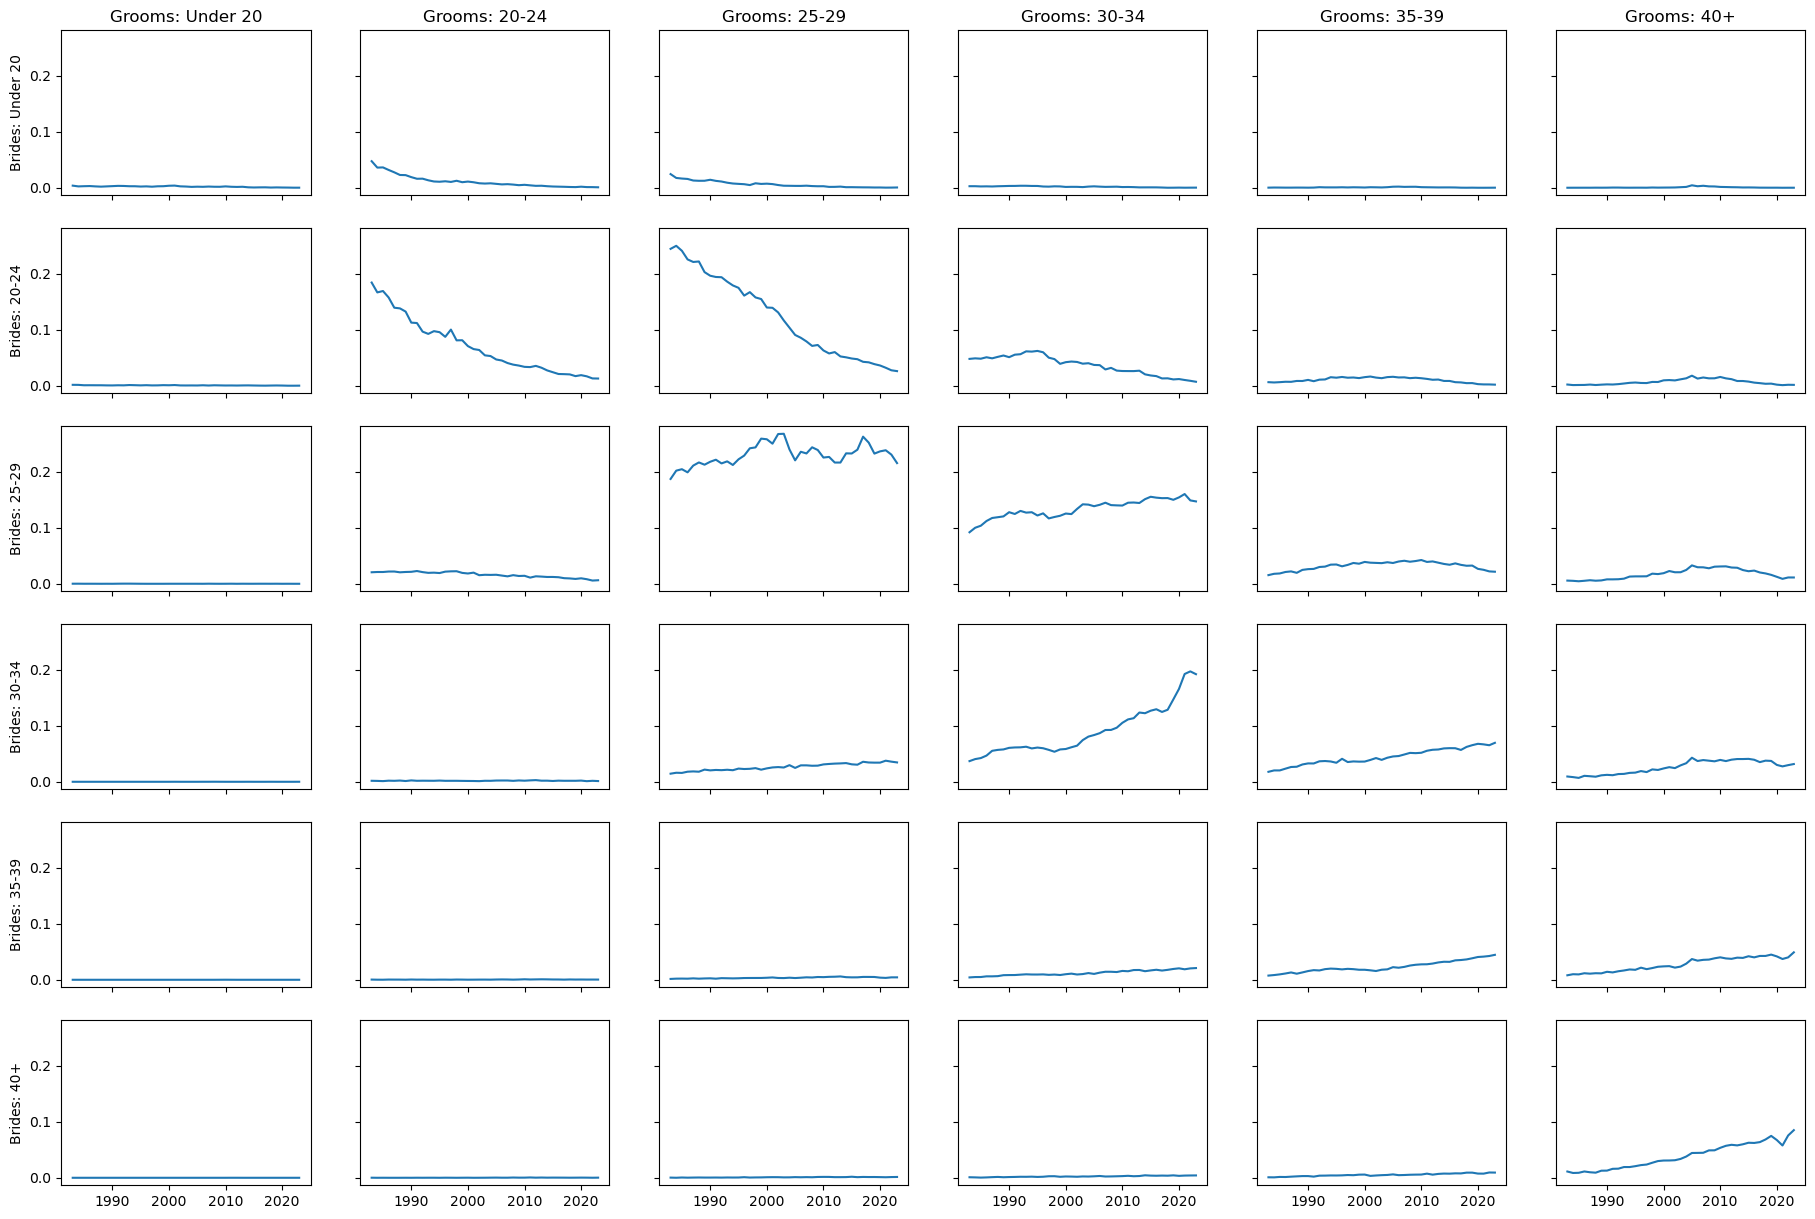

In [5]:
def _plot_multicol_data(data:pd.DataFrame, x_level:str, y_level:str)->tuple[plt.Figure,axes.Axes]:
    x_levels = data.columns.unique(x_level)
    y_levels = data.columns.unique(y_level)
    n_x = x_levels.nunique()
    n_y = y_levels.nunique()
    h = n_x * 2.5
    w = n_y * (2.5 * (3 / 2))
    fig, axs = plt.subplots(n_x, n_y, figsize=(w, h), sharex=True, sharey=True)
    for x in x_levels:
        i_x = x_levels.get_indexer_for([x])[0]
        axs[i_x][0].set_ylabel(f'{x_level.title()}: {x}')
        for y in y_levels:
            i_y = y_levels.get_indexer_for([y])[0]
            ax_xy:axes.Axes = axs[i_x][i_y]
            ax_xy.set_facecolor(('white', 0.2))
            if i_x == 0:
                ax_xy.set_title(f'{y_level.title()}: {y}')
            try:
                plot_data = data.xs((x,y,), 1, (x_level,y_level,)).copy(deep=True)
                if plot_data.columns.size == 1:
                    plot_data = plot_data.iloc[:,0]
                sns.lineplot(plot_data, ax=ax_xy)
            except:
                pass
    fig.get_tight_layout()
    fig.set_facecolor(('white', 0.3))
    return fig, axs
df_pct = df.apply(lambda row: row / row[('Total', 'Total', 'Groom = Bride')], axis=1)
_df_pct = df_pct.droplevel(level=['comparison'], axis=1).copy(deep=True)
fig, axs = _plot_multicol_data(df_pct.drop(columns=['Total'], level='brides').drop(columns=['Total'], level='grooms'), x_level='brides', y_level='grooms')
plt.show()
fig.clf()
plt.close()

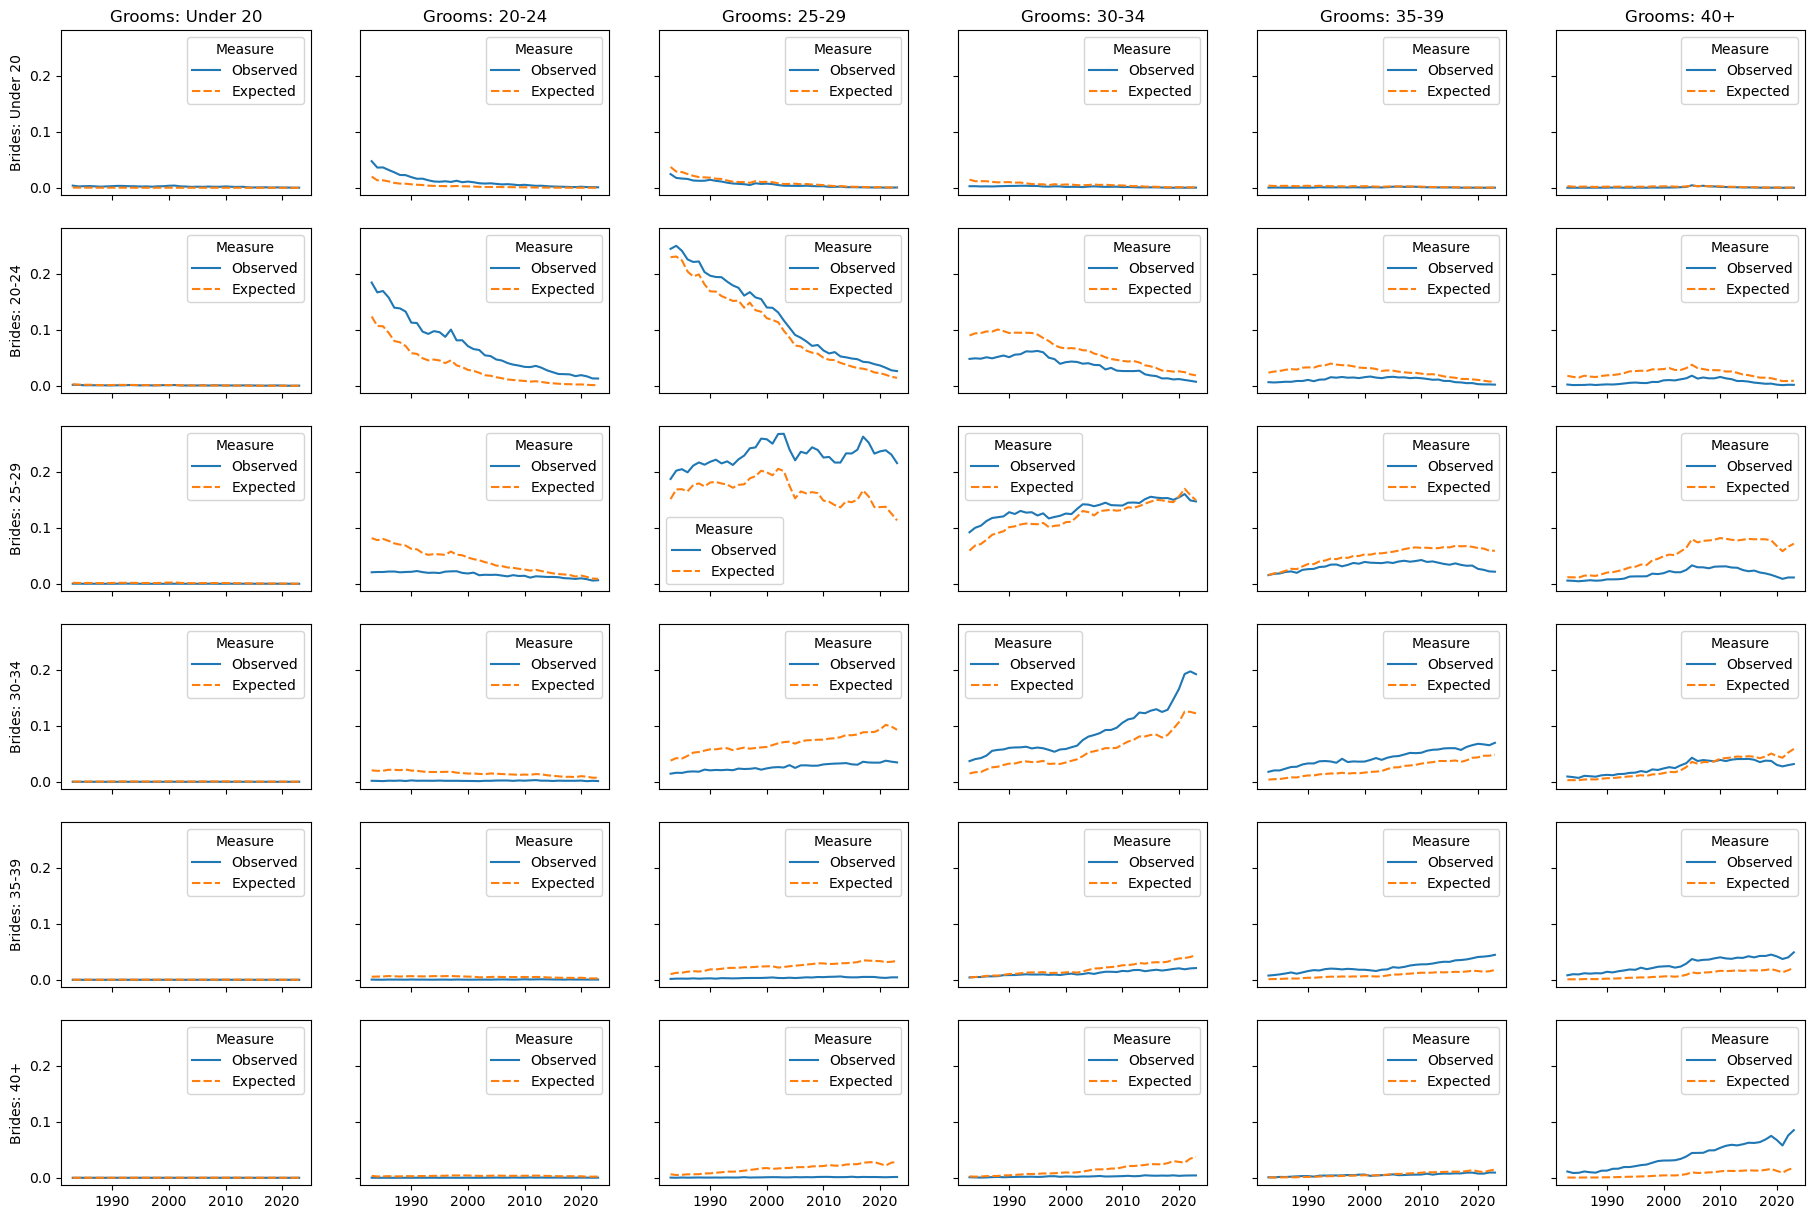

In [6]:
df_pct_margin = pd.concat({
    b_lvl: _df_pct.xs(('Total',), 1, ('brides',)).apply(lambda row: row * _df_pct.loc[row.name,(b_lvl,'Total')], axis=1)
    for b_lvl in _df_pct.columns.unique('brides')
}, axis=1, names=['brides', 'grooms'])
df_pct_margin = pd.concat({
    'Observed': _df_pct, 'Expected': df_pct_margin, 
}, axis=1, names=['Measure', 'brides', 'grooms'])
_df_pct_margin = df_pct_margin.drop(columns=['Total'], level='brides').drop(columns=['Total'], level='grooms').copy(deep=True)
fig, axs = _plot_multicol_data(_df_pct_margin, x_level='brides', y_level='grooms')
fig.savefig('./agegroup.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()

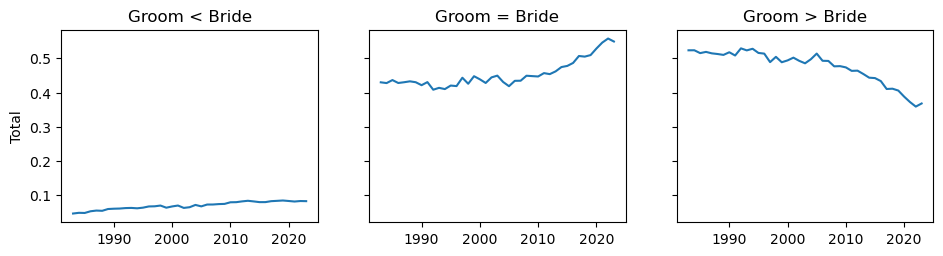

In [7]:
def _plot_singlecol_data(data:pd.DataFrame, ylabel:str)->tuple[plt.Figure,axes.Axes]:
    y_levels = data.columns.unique()
    n_y = y_levels.nunique()
    h = 1 * 2.5
    w = n_y * (2.5 * (3 / 2))
    fig, axs = plt.subplots(1, n_y, figsize=(w, h), sharex=True, sharey=True)
    axs[0].set_ylabel(ylabel)
    for y in y_levels:
        i_y = y_levels.get_indexer_for([y])[0]
        ax_y:axes.Axes = axs[i_y]
        ax_y.set_title(y)
        try:
            sns.lineplot(data.loc[:,y], ax=ax_y)
        except:
            pass
    fig.get_tight_layout()
    return fig, axs
df_comp_pct = df_pct.drop(columns=['Total'], level='brides').drop(columns=['Total'], level='grooms').T.groupby(by=['comparison'], observed=True).sum().T.copy(deep=True)
fig, axs = _plot_singlecol_data(df_comp_pct, 'Total')
plt.show()
fig.clf()
plt.close()

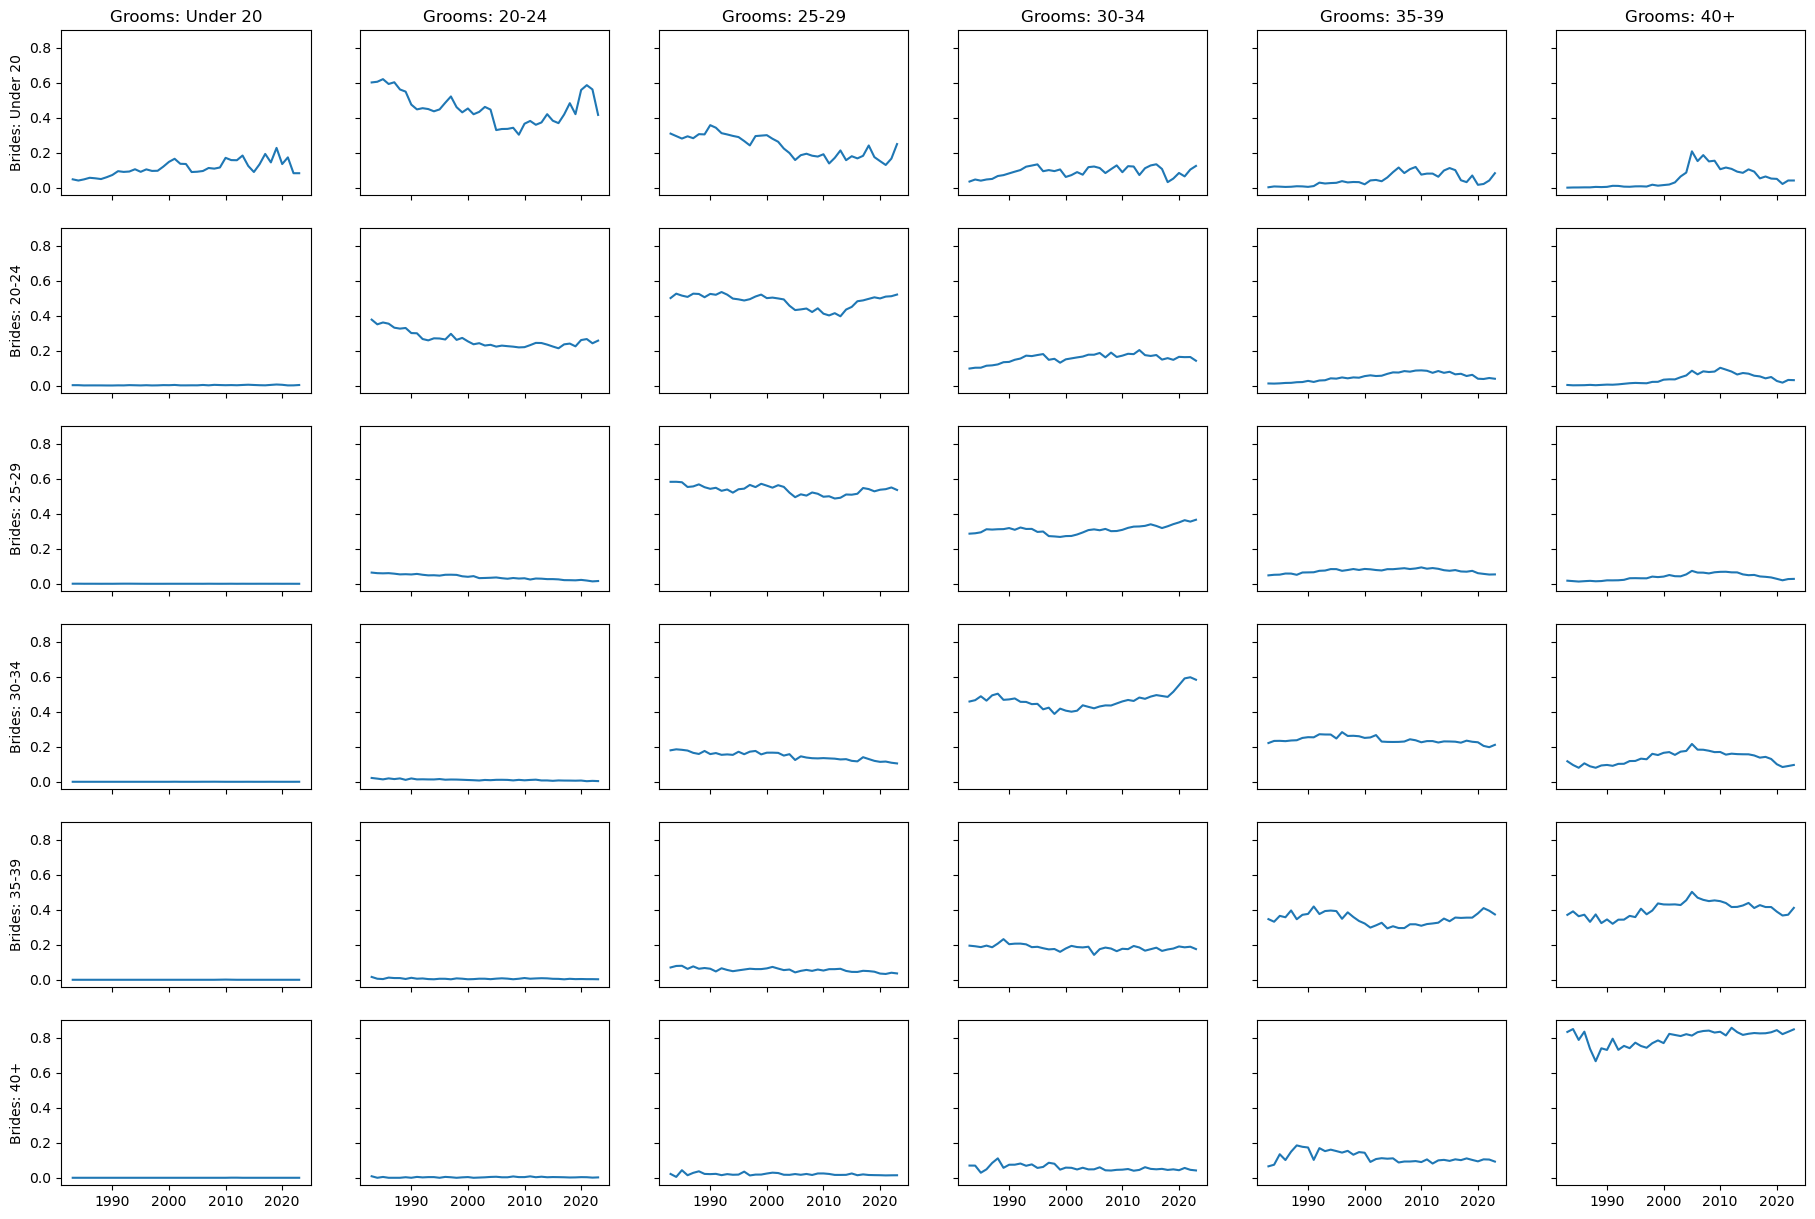

In [ ]:
df_bride_pct = df_pct.div(df_pct.xs(('Total',), 1, ('grooms',)).droplevel(level=['comparison'], axis=1)).droplevel(level=['comparison'], axis=1)
_df_bride_pct = df_bride_pct.drop(columns=['Total'], level='brides').drop(columns=['Total'], level='grooms').copy(deep=True)
fig, axs = _plot_multicol_data(_df_bride_pct, x_level='brides', y_level='grooms')







d






plt.show()
fig.clf()
plt.close()

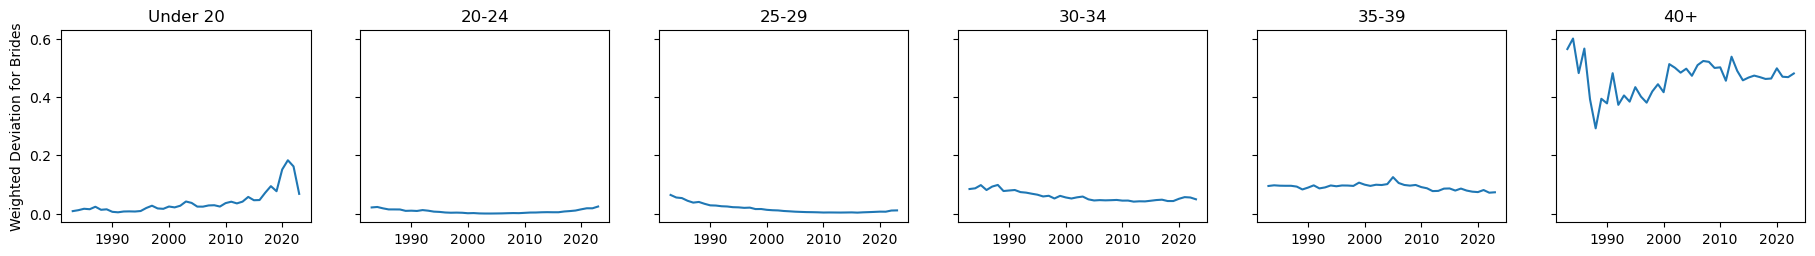

In [9]:
df_bride_pct_dev = _df_bride_pct.subtract(df_pct.droplevel(level=['comparison'], axis=1).xs(('Total',), 1, ('grooms',)).rename_axis(columns=['grooms'])).pow(2)
df_bride_pct_dev = df_bride_pct_dev.mul(_df_bride_pct)
df_bride_pct_dev = df_bride_pct_dev.T.groupby(by=['brides'], observed=True).sum().div(_df_bride_pct.T.groupby(by=['brides'], observed=True).sum()).T
fig, axs = _plot_singlecol_data(df_bride_pct_dev, 'Weighted Deviation for Brides')
plt.show()
fig.clf()
plt.close()

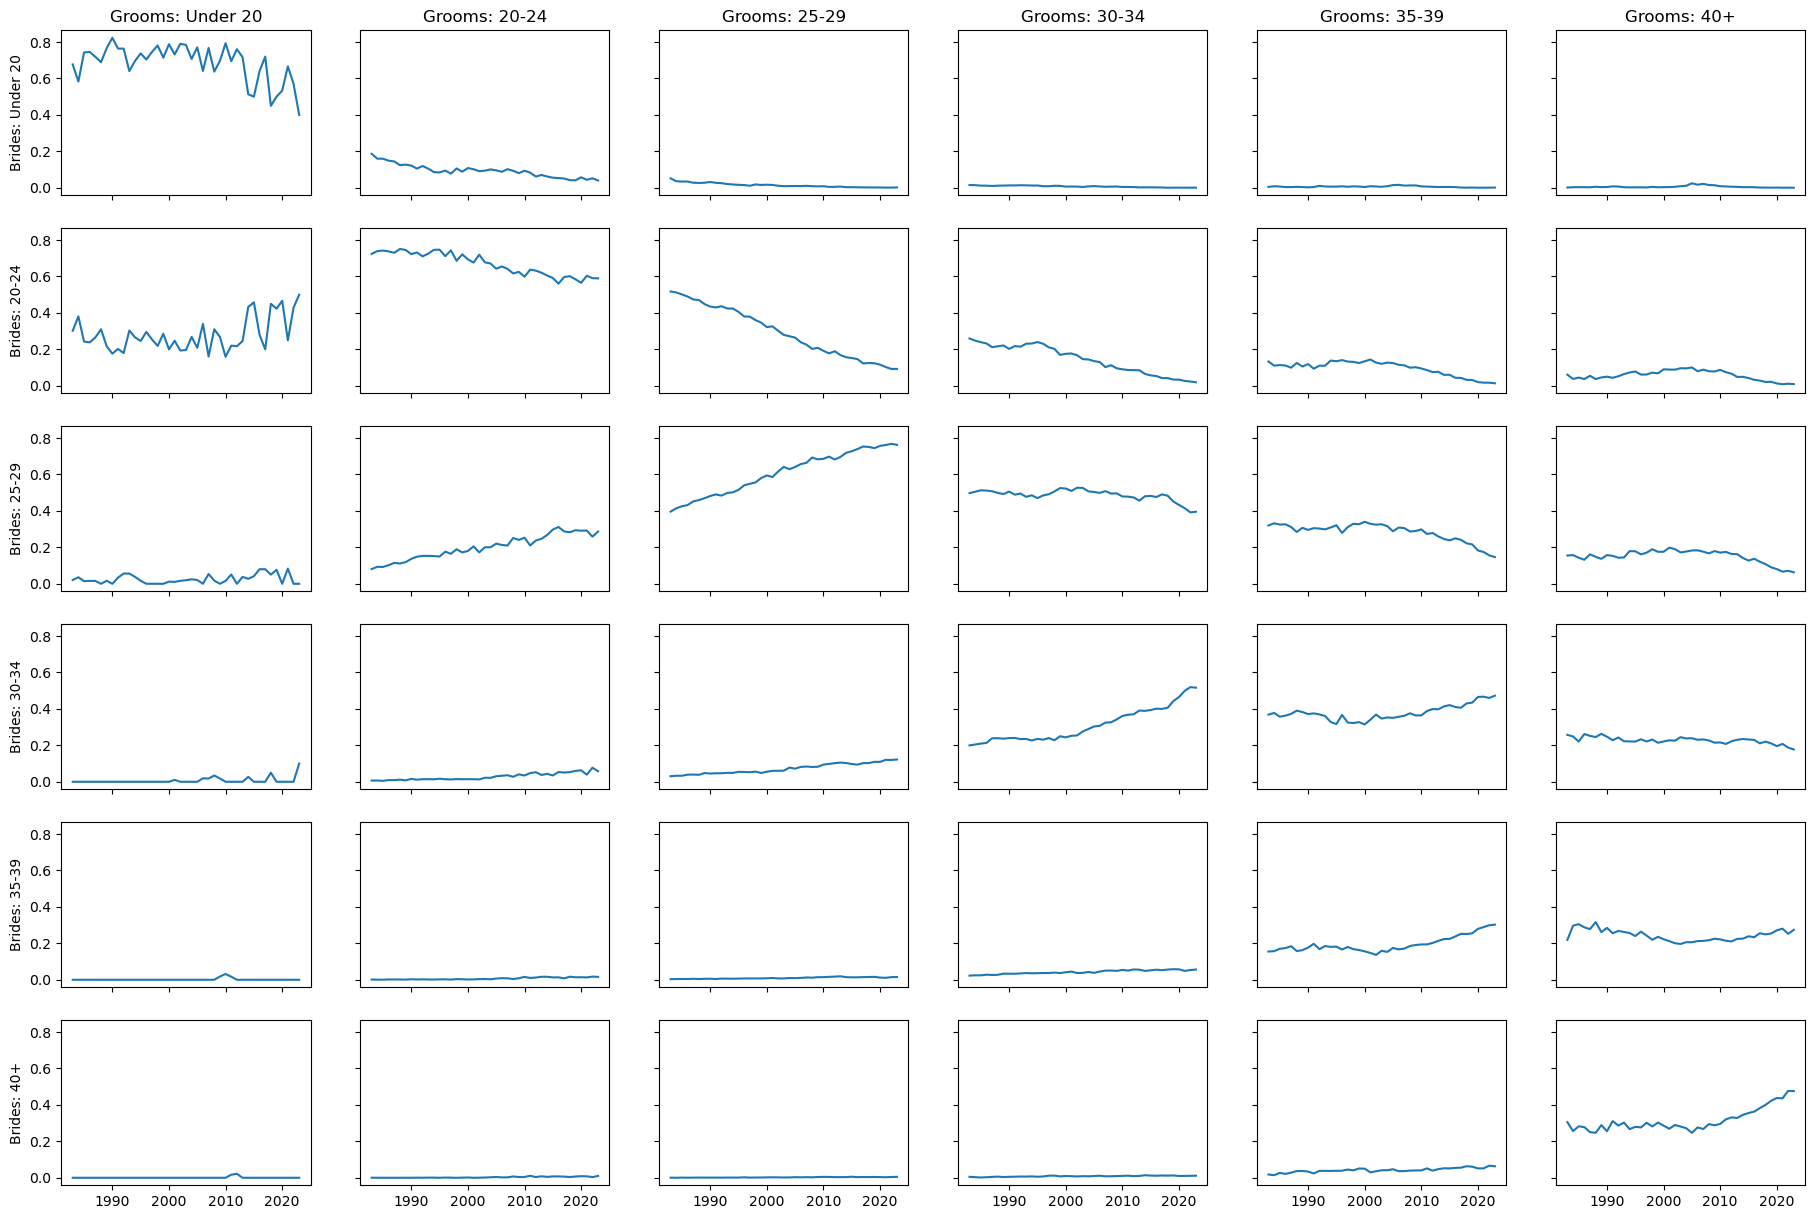

In [10]:
df_groom_pct = df_pct.div(df_pct.xs(('Total',), 1, ('brides',)).droplevel(level=['comparison'], axis=1)).droplevel(level=['comparison'], axis=1)
_df_groom_pct = df_groom_pct.drop(columns=['Total'], level='brides').drop(columns=['Total'], level='grooms').copy(deep=True)
fig, axs = _plot_multicol_data(_df_groom_pct, x_level='brides', y_level='grooms')
plt.show()
fig.clf()
plt.close()

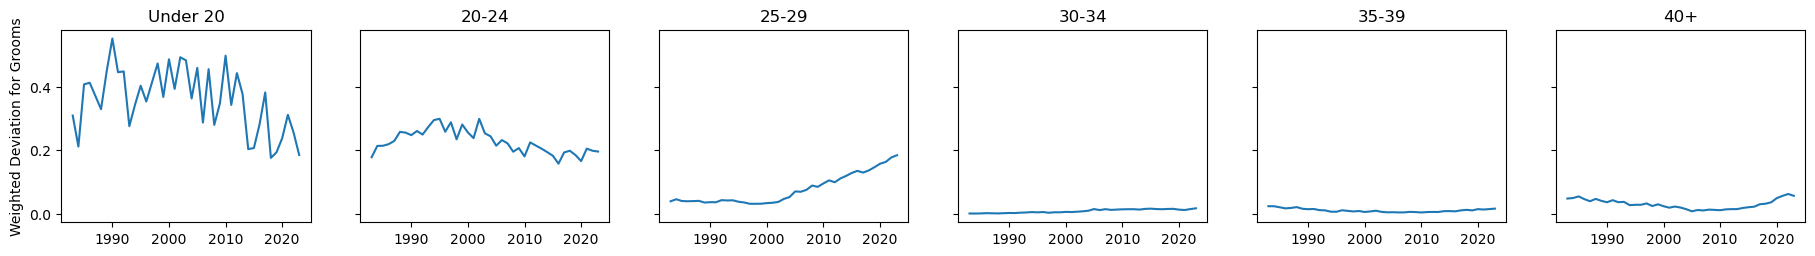

In [11]:
df_groom_pct_dev = _df_groom_pct.subtract(df_pct.droplevel(level=['comparison'], axis=1).xs(('Total',), 1, ('brides',)).rename_axis(columns=['brides'])).pow(2)
df_groom_pct_dev = df_groom_pct_dev.mul(_df_groom_pct)
df_groom_pct_dev = df_groom_pct_dev.T.groupby(by=['grooms'], observed=True).sum().div(_df_groom_pct.T.groupby(by=['grooms'], observed=True).sum()).T
fig, axs = _plot_singlecol_data(df_groom_pct_dev, 'Weighted Deviation for Grooms')
plt.show()
fig.clf()
plt.close()